# Run PESTPP-OPT

In this notebook we will setup and solve a mgmt optimization problem around how much groundwater can be pumped while maintaining sw-gw exchange

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu
%matplotlib inline

flopy is installed in /Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy


## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 20

In [3]:
t_d = "template_history"
m_d = "master_opt"

### We can look at the summary information about the parameters

In [4]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none").sort_index()

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,0.176091,-0.30103,0.11928
cn_prsity7,cn_prsity7,log,1,0,0.176091,-0.30103,0.11928
...,...,...,...,...,...,...,...
pp_vka0,pp_vka0,log,32,0,1,-1,0.5
pp_vka1,pp_vka1,log,32,0,1,-1,0.5
pp_vka2,pp_vka2,log,32,0,1,-1,0.5
welflux,welflux,log,25,0,1,-1,0.5


### define our decision variable group and also set some `++args`.

Conceptually, we are going to optimize current pumping rates to make sure we meet ecological flows under both historic (current) conditions and scenario (future) conditions.  Remember the scenario is an extreme 1-year drought, so if we pump too much now, the system will be too low to provide critical flows if next year is an extreme drough - transient memory!

Define a parameter group as the devision variables (i.e. the variables that we will tune to meet the optimal condition). We will define `wellflux_k02` as the decision variable group (defined by the `++arg` called `opt_dec_var_groups`. Note in the table above that this group represents (time-invariant) flux mulipliers for each of the 6 wells (we will however only optimize for pumping rates in current (historic) conditions). 

We can also define which direction we want the optimization to go using `opt_direction` as `max`. This means the objective of the optimization will be to maximize future pumping subject to the constraints we will establish below.


In [5]:
pst.pestpp_options = {}
#dvg = ["welflux_k02","welflux"]
dvg = ["welflux_k02"]  # time-invariant flux multiplier for each well
pst.pestpp_options["opt_dec_var_groups"] = dvg
pst.pestpp_options["opt_direction"] = "max"

For the first run, we won't use chance constraints, so just fix all non-decision-variable "parameters".  We also need to set some realistic bounds on the `welflux` multiplier decision variables.  Finally, we need to specify a larger derivative increment for the decision varible group. For typical parameter estimation, `derinc=0.01` is often sufficient for calculating a Jacobian matrix. But, for the response matrix method of optimization, the response can be subtle requiring a greater perturbation increment. We will set it to `0.25` using some `pandas` manipulation.

In [6]:
par = pst.parameter_data
par.loc[:,"partrans"] = "fixed"

temporal_wel_pars = par.loc[par.parnme.apply(lambda x: "welflux" in x),"parnme"]
#print(temporal_wel_pars)
#par.loc[temporal_wel_pars,"parlbnd"] = 0.0 
par.loc[temporal_wel_pars,"parval1"] = 1.0

# # dec vars
dvg_pars = par.loc[par.pargp.apply(lambda x: x in dvg),"parnme"]
par.loc[dvg_pars,"partrans"] = "none"
par.loc[dvg_pars,"parlbnd"] = 0.0
par.loc[dvg_pars,"parubnd"] = 3.0  # corresponds to -450 m3/d
par.loc[dvg_pars,"parval1"] = 1.0

par.loc[dvg_pars,:]

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
wf0200090016,wf0200090016,none,factor,1.0,0.0,3.0,welflux_k02,1.0,0.0,1,NaN
wf0200110013,wf0200110013,none,factor,1.0,0.0,3.0,welflux_k02,1.0,0.0,1,NaN
wf0200200014,wf0200200014,none,factor,1.0,0.0,3.0,welflux_k02,1.0,0.0,1,NaN
wf0200260010,wf0200260010,none,factor,1.0,0.0,3.0,welflux_k02,1.0,0.0,1,NaN
wf0200290006,wf0200290006,none,factor,1.0,0.0,3.0,welflux_k02,1.0,0.0,1,NaN
wf0200340012,wf0200340012,none,factor,1.0,0.0,3.0,welflux_k02,1.0,0.0,1,NaN


In [7]:
pst.rectify_pgroups()
pst.parameter_groups.loc[dvg,"inctyp"] = "absolute"
pst.parameter_groups.loc[dvg,"inctyp"] = "absolute"
pst.parameter_groups.loc[dvg,"derinc"] = 0.25

pst.parameter_groups.loc[dvg,:]

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd,splitthresh,splitreldiff,splitaction,extra
pargpnme,,,,,,,,,,,
welflux_k02,welflux_k02,absolute,0.25,0.0,switch,2.0,parabolic,1.0000000000e-05,5.0000000000e-01,smaller,NaN


### define constraints

Model-based or dec var-related constraints are identified in `pestpp-opt` by an obs or prior information group that starts with "less_than" or "greater_than" and a weight greater than zero.  So first, we turn off all of the weights and get names for the sw-gw exchange forecasts (funny how optimization turns forecasts into constraints...)

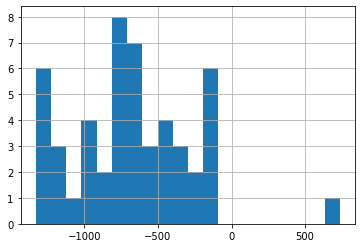

In [8]:
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0
swgw_const = obs.loc[obs.obsnme.apply(lambda x: "fa" in x and ("hw" in x or "tw" in x)),"obsnme"]
obs.loc[swgw_const,:].obsval.hist(bins=20)

We need to change the obs group (`obgnme`) so that `pestpp-opt` will recognize these model outputs as constraints.  The `obsval` becomes the RHS of the constraint.  

In [9]:
obs.loc[swgw_const,"obgnme"] = "less_than"
obs.loc[swgw_const,"weight"] = 1.0

# we must have at least 300 m3/day of flux from gw to sw
# for historic and scenario periods
# and for both headwaters and tailwaters
obs.loc[swgw_const,"obsval"] = -100

Now we need to define a minimum total pumping rate, otherwise this opt problem might yield a solution that doesn't give enough water for the intended usage.  We will do this through a prior information constraint since this just a sum of decision variable values - the required minimum value will the sum of current pumping rates:

In [10]:
pyemu.pst_utils.pst_config["prior_fieldnames"]

['pilbl', 'equation', 'weight', 'obgnme']

Since all pumping wells are using the same rate and are of same "water supply benefit", we can just use a `1.0` multiplier in front of each `wel.flux` decision varialbe.  If that is not the case, then you need to set the multipliers to be more meaningful

In [11]:
pi = pst.null_prior
pi.loc["pi_1","obgnme"] = "greater_than"
pi.loc["pi_1","pilbl"] = "pi_1"
pi.loc["pi_1","equation"] = " + ".join(["1.0 * {0}".format(d) for d in dvg_pars]) +\
                            " = {0}".format(par.loc[dvg_pars,"parval1"].sum())
pi.loc["pi_1","weight"] = 1.0
pi.equation["pi_1"]

'1.0 * wf0200090016 + 1.0 * wf0200110013 + 1.0 * wf0200200014 + 1.0 * wf0200260010 + 1.0 * wf0200290006 + 1.0 * wf0200340012 = 6.0'

In [12]:
pst.prior_information

,pilbl,obgnme,equation,weight
pi_1,pi_1,greater_than,1.0 * wf0200090016 + 1.0 * wf0200110013 + 1.0 * wf0200200014 + 1.0 * wf0200260010 + 1.0 * wf0200...,1.0


## now for a risk-neutral optimization (ignoring uncertainty in constraints)

#### Note that setting `noptmax=1` is equivalent to selecting Linear Programming (LP) as the optimization algorithm (thus assuming a linear response matrix).

#### A higher value of `noptmax` runs Sequential Linear Programming (SLP)

In [13]:
pst.control_data.noptmax = 1
pst.write(os.path.join(t_d,"freyberg_opt.pst"))
pyemu.os_utils.start_workers(t_d,"pestpp-opt","freyberg_opt.pst",num_workers=num_workers,master_dir=m_d)

noptmax:1, npar_adj:6, nnz_obs:50


Let's load and inspect the response matrix

In [14]:
jco = pyemu.Jco.from_binary(os.path.join(m_d,"freyberg_opt.1.jcb")).to_dataframe().loc[pst.less_than_obs_constraints,:]
jco

,wf0200090016,wf0200110013,wf0200200014,wf0200260010,wf0200290006,wf0200340012
fa_hw_20160101,140.89200,130.94000,48.308000,24.83200,21.71600,5.72800
fa_hw_20160201,106.36400,107.84800,41.204000,24.59600,21.76000,5.73600
fa_hw_20160301,92.02000,94.87200,36.836000,24.06800,21.70800,5.74000
fa_hw_20160401,94.25200,93.67200,35.912000,23.32800,21.52400,5.66800
fa_hw_20160501,111.12400,103.92000,38.644000,22.72400,21.20000,5.58000
fa_hw_20160601,137.45200,122.56800,44.368000,22.60800,20.98400,5.50400
fa_hw_20160701,164.22400,142.97600,50.972000,22.88800,20.79200,5.44800
fa_hw_20160801,179.00400,156.30800,55.692000,23.53200,20.72000,5.41200
fa_hw_20160901,194.13200,169.21200,60.308000,24.46000,20.82000,5.43600
fa_hw_20161001,199.33800,175.55680,62.836000,25.52400,21.11600,5.52800


We see the transient effects in the nonzero value between current pumping rates (columns) and scenario sw-gw exchange (rows from 1980) and that the current 1979 sw-gw exchanges are always larger than those in the scenario 1980 condition.

Let's also load the optimal decision variable values:

In [15]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

9.63377347766336


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,2.212760,1.0,0.0
wf0200110013,wf0200110013,3.000000,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,0.000000,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,1.421013,1.0,0.0


The sum of these values is the optimal objective function value. However, since these are just mulitpliers on the pumping rate, this number isnt too meaningful. Instead, lets look at the residuals file

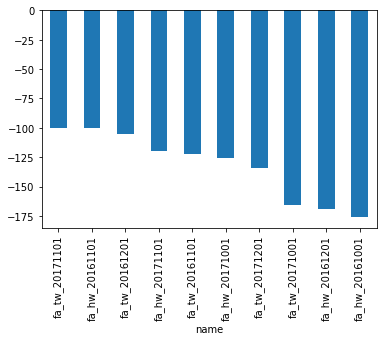

In [16]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_opt.pst"),resfile=os.path.join(m_d,"freyberg_opt.1.sim.rei"))
pst.res.loc[pst.nnz_obs_names,:].sort_values(by="modelled",ascending=False).modelled.iloc[:10].plot(kind="bar")

we can see the "binding constraints" as those at -100

We better also check that our prior information constraint (min total abstracted water allocation) is being met..

In [17]:
pst.res.loc[pst.prior_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
pi_1,pi_1,greater_than,6.0,9.633773,3.633773,1.0


### Opt under uncertainty part 1: FOSM chance constraints

This is where the process of uncertainty quantification/history matching and mgmt optimizatiom meet - worlds collide! 

Mechanically, in PESTPP-OPT, to activate the chance constraint process, we need to specify a `risk != 0.5`.  Risk ranges from 0.001 (risk tolerant) to 0.999 (risk averse).  The larger the risk value, the more confidence we have that the (uncertain) model-based constraints are truely satisfied.  Here we will start with a risk tolerant stance:

In [18]:
pst.pestpp_options["opt_risk"] = 0.4

For the FOSM-based chance constraints, we also need to have at least one adjustable non-dec-var parameter so that we can propogate parameter uncertainty to model-based constraints (this can also be posterior FOSM is non-constraint, non-zero-weight observations are specified).  For this simple demo, lets just use the constant multiplier parameters in the prior uncertainty stance:

In [19]:
cn_pars = par.loc[par.pargp.apply(lambda x: "cn" in x),"parnme"]
cn_pars

parnme
const_hk6__cn            const_hk6__cn
const_hk7__cn            const_hk7__cn
const_hk8__cn            const_hk8__cn
const_prsity6__cn    const_prsity6__cn
const_prsity7__cn    const_prsity7__cn
const_prsity8__cn    const_prsity8__cn
const_rech10__cn      const_rech10__cn
const_rech11__cn      const_rech11__cn
const_rech12__cn      const_rech12__cn
const_rech13__cn      const_rech13__cn
const_rech14__cn      const_rech14__cn
const_rech15__cn      const_rech15__cn
const_rech16__cn      const_rech16__cn
const_rech17__cn      const_rech17__cn
const_rech18__cn      const_rech18__cn
const_rech19__cn      const_rech19__cn
const_rech20__cn      const_rech20__cn
const_rech21__cn      const_rech21__cn
const_rech22__cn      const_rech22__cn
const_rech23__cn      const_rech23__cn
const_rech24__cn      const_rech24__cn
const_rech25__cn      const_rech25__cn
const_rech26__cn      const_rech26__cn
const_rech2__cn        const_rech2__cn
const_rech3__cn        const_rech3__cn
const_rech4__cn   

In [20]:
par = pst.parameter_data
par.loc[cn_pars,"partrans"] = "log"
pst.control_data.noptmax = 1
pst.write(os.path.join(t_d,"freyberg_opt_uu1.pst"))

noptmax:1, npar_adj:46, nnz_obs:50


So now we need to not only fill the response matrix (between dec vars and constraints) but we also need to fill the jacobian matrix (between parameters and constraints).  Given that we only have 6 decision variables, let's just re-populate the response matrix while also populating the Jacobian.

In [21]:
pyemu.os_utils.start_workers(t_d,"pestpp-opt","freyberg_opt_uu1.pst",num_workers=num_workers,master_dir=m_d)

What do we expect to see here?  What should happen to the optimal dec vars? And the constraints?

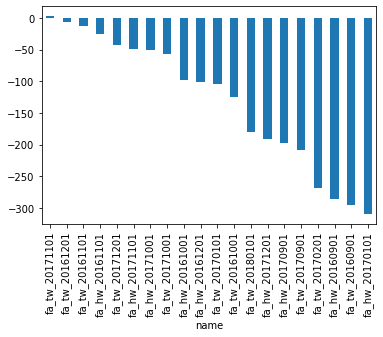

In [22]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_opt_uu1.pst"),resfile=os.path.join(m_d,"freyberg_opt_uu1.1.sim.rei"))
pst.res.loc[pst.nnz_obs_names,:].sort_values(by="modelled",ascending=False).modelled.iloc[:20].plot(kind="bar")

Wait - was the constraint that sw-gw flux had to be less than -100?  How do we have some many constraints greater than -100???

In [23]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_uu1.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

10.924919516248119


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,2.581250,1.0,0.0
wf0200110013,wf0200110013,3.000000,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,0.000000,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,2.343669,1.0,0.0


We now see how taking a risk tolerant stance allows for more pumping but that we have only a 40% chance of actually satifying the sw-gw constraints (see how the model simulated value is actually in violation of the -100 constraint RHS).  Lets check the residuals that include the FOSM-based chance constraint shift:

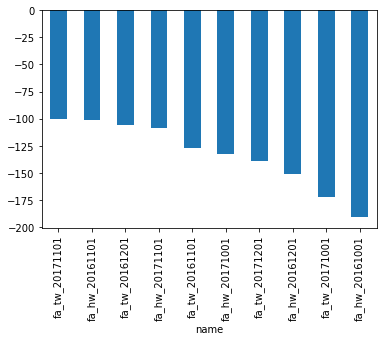

In [24]:
res_df = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_uu1.1.sim+fosm.rei")).loc[pst.nnz_obs_names,:]
res_df.sort_values(by="modelled",ascending=False).modelled.iloc[:10].plot(kind="bar")

See what is happening?  Because we were risk tolerant, we actually subtracted some sw-gw flux from the values from MODFLOW - effectively acounting for additional sw-gw that wasnt acutally simulated.  This flux is in the uncertainty in the simulated sw-gw flux.  And since we were "aggresive" with our risk-stance, we can exploit this uncertainty to extract additional groundwater.

### Opt under uncertainty part 2: ensemble-based chance constraints

PESTPP-OPT can also skip the FOSM calculations if users specify model-based constraint weights as standard deviations (i.e. uncertainty in the forecasts/constraints).  These can be derived from our existing ensembles (oh snap!)

In [25]:
obs_df = pd.read_csv(os.path.join("master_prior_sweep","sweep_out.csv"),index_col=0)
obs_df = obs_df.loc[obs_df.failed_flag==0,:]

In [26]:
pr_std = obs_df.std().loc[pst.nnz_obs_names]
pr_std

fa_hw_20160101    649.022270
fa_hw_20160201    537.492482
fa_hw_20160301    512.617325
fa_hw_20160401    508.606226
fa_hw_20160501    510.975210
fa_hw_20160601    558.365999
fa_hw_20160701    650.179044
fa_hw_20160801    680.296198
fa_hw_20160901    713.220583
fa_hw_20161001    716.034436
fa_hw_20161101    682.015640
fa_hw_20161201    601.477058
fa_hw_20170101    525.649560
fa_hw_20170201    485.725764
fa_hw_20170301    465.918668
fa_hw_20170401    450.258476
fa_hw_20170501    456.894570
fa_hw_20170601    516.477431
fa_hw_20170701    618.160303
fa_hw_20170801    727.842918
fa_hw_20170901    786.389735
fa_hw_20171001    811.132475
fa_hw_20171101    803.307338
fa_hw_20171201    783.009103
fa_hw_20180101    737.557921
fa_tw_20160101    723.027231
fa_tw_20160201    619.420656
fa_tw_20160301    580.010836
fa_tw_20160401    561.853158
fa_tw_20160501    571.767246
fa_tw_20160601    615.811437
fa_tw_20160701    682.153867
fa_tw_20160801    697.415968
fa_tw_20160901    705.798105
fa_tw_20161001

Note we can also skip the FOSM calcs within `PESTPP-OPT` using weights as per previous FOSM standard deviation calcs, not just ensemble-based standard deviations

In [27]:
pst.observation_data.loc[pst.nnz_obs_names,"weight"] = pr_std.loc[pst.nnz_obs_names]
pst.pestpp_options["opt_std_weights"] = True
pst.write(os.path.join(t_d,"freyberg_opt_uu2.pst"))

noptmax:1, npar_adj:46, nnz_obs:50


In [28]:
pyemu.os_utils.start_workers(t_d,"pestpp-opt","freyberg_opt_uu2.pst",num_workers=num_workers,master_dir=m_d)

In [29]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_uu2.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

11.966450329127152


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.00000,1.0,0.0
wf0200110013,wf0200110013,3.00000,1.0,0.0
wf0200200014,wf0200200014,0.00000,1.0,0.0
wf0200260010,wf0200260010,0.00000,1.0,0.0
wf0200290006,wf0200290006,3.00000,1.0,0.0
wf0200340012,wf0200340012,2.96645,1.0,0.0


Why is the objective function higher when we use the ensemble-based constraint uncertainty compared to the FOSM constraint uncertainty?  Remember how many more parameters were used in the ensemble analyses compared to just the hand full of constant by layer parameters that we used for the FOSM calcs within PESTPP-OPT?

### Super secret mode for `LP`

It turns out, if the opt problem is truely linear, we can reuse results of a previous PESTPP-OPT run to modify lots of the pieces of the optimization problem and resolve the optimization problem without running the model even once!  WAT!? 

As long as the same decision variables are relates to the same responses, and we can fairly assume that the response matrix that relates the decision variables to the constraints is linear, then the response matrix doesn't change even if things like bounds and risk level change. We just need `pestpp-opt` to read in the response matrix (which is stored with the same format as a Jacobian (`jcb`)) and the residuals (`rei`). 

This is done by specifying some additional `++args` (and copying some files around)

In [30]:
shutil.copy2(os.path.join(m_d,"freyberg_opt_uu2.1.jcb"),os.path.join(m_d,"restart.jcb"))
shutil.copy2(os.path.join(m_d,"freyberg_opt_uu2.1.jcb.rei"),os.path.join(m_d,"restart.rei"))

'master_opt/restart.rei'

Once we have copied over the necessary files, we set a few `++args`:  
* `base_jacobian`: this instructs `pestpp-opt` to read in the existing response matrix
* `hotstart_resfile`: this instructs `pestpp-opt` to use the residuals we already have
* `opt_skip_final`: this waives the usual practice of running the model once with optimal parameter values

Which runs do each of these skip specifically?

In [31]:
pst.pestpp_options["base_jacobian"] = "restart.jcb"
pst.pestpp_options["hotstart_resfile"] = "restart.rei"
pst.pestpp_options["opt_skip_final"] = True
pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))

noptmax:1, npar_adj:46, nnz_obs:50


In [32]:
pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)

In [33]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_restart.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

11.966450329127152


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.00000,1.0,0.0
wf0200110013,wf0200110013,3.00000,1.0,0.0
wf0200200014,wf0200200014,0.00000,1.0,0.0
wf0200260010,wf0200260010,0.00000,1.0,0.0
wf0200290006,wf0200290006,3.00000,1.0,0.0
wf0200340012,wf0200340012,2.96645,1.0,0.0


Oh snap!  that means we can do all sort of kewl optimization testing really really fast...

## now let's try taking a risk averse stance

In [34]:
risk = 0.55

In [35]:
pst.pestpp_options["opt_risk"] = risk
pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))
pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)

noptmax:1, npar_adj:46, nnz_obs:50


In [36]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_restart.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

8.360882787343918


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,2.183962,1.0,0.0
wf0200110013,wf0200110013,2.559595,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,0.000000,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,0.617326,1.0,0.0


### now lets evaluate how our OUU problem changes if we use posterior standard deviations - this is a critically important use of the uncertainty analysis from history matching...

This is where all that painful history-matching finally has a real-world (and valid) purpose: to reduce the uncertainty in the constraints for a decision-support optimization problem

In [37]:
obs_df = pd.read_csv(os.path.join("master_ies","freyberg_ies.3.obs.csv"),index_col=0)

#df = df=pd.read_csv(os.path.join("master_glm","freyberg_pp.post.obsen.csv"),index_col=0)
#obs_df = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)
#obs_df = obs_df.loc[obs_df.phi_vector.sort_values().index[:20],:] 
pt_std = obs_df.std().loc[pst.nnz_obs_names]
obs_df.std().loc[pst.nnz_obs_names]
#obs_df.max().loc[pst.nnz_obs_names]

fa_hw_20160101    570.558995
fa_hw_20160201    469.307892
fa_hw_20160301    468.305856
fa_hw_20160401    463.824248
fa_hw_20160501    456.235615
fa_hw_20160601    407.846258
fa_hw_20160701    453.921680
fa_hw_20160801    440.766484
fa_hw_20160901    399.121861
fa_hw_20161001    401.068748
fa_hw_20161101    405.780251
fa_hw_20161201    405.783893
fa_hw_20170101    371.754744
fa_hw_20170201    396.658928
fa_hw_20170301    399.811178
fa_hw_20170401    398.770553
fa_hw_20170501    507.063400
fa_hw_20170601    458.092760
fa_hw_20170701    563.307761
fa_hw_20170801    719.981288
fa_hw_20170901    706.660822
fa_hw_20171001    795.336556
fa_hw_20171101    778.475826
fa_hw_20171201    686.705427
fa_hw_20180101    618.045360
fa_tw_20160101    471.610836
fa_tw_20160201    396.448305
fa_tw_20160301    373.059558
fa_tw_20160401    350.142156
fa_tw_20160501    355.684872
fa_tw_20160601    422.939496
fa_tw_20160701    469.061068
fa_tw_20160801    450.988301
fa_tw_20160901    441.616976
fa_tw_20161001

How much lower is the posterior standard deviations as compared to the prior?

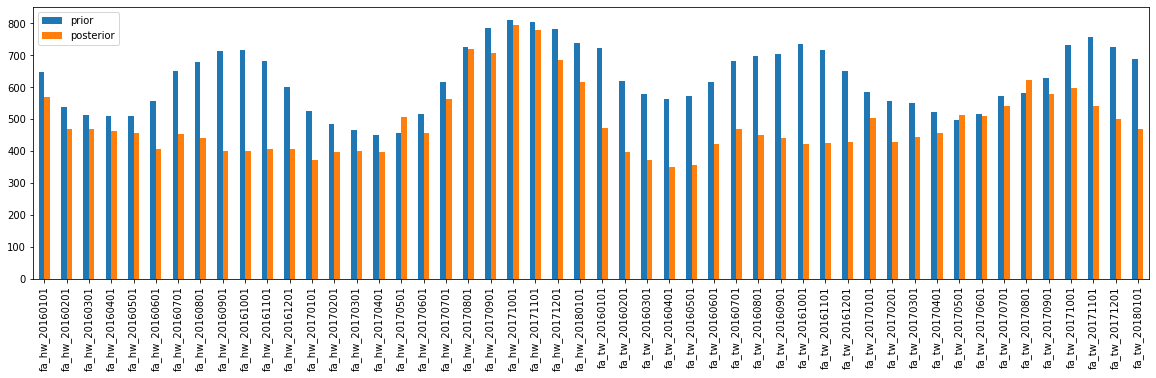

In [38]:
pd.DataFrame({"prior":pr_std,"posterior":pt_std}).plot(kind="bar",figsize=(20,5))

This implies that the chance constraints (which express the important model input uncertainty propogated to the forecast/constraints) is significantly lower, meaning uncertainty has less "value" in the optimization objective function

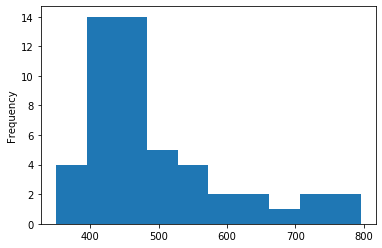

In [39]:
pst.observation_data.loc[pst.nnz_obs_names,"weight"] = pt_std.loc[pst.nnz_obs_names]
pst.observation_data.loc[pst.nnz_obs_names,"weight"].plot(kind="hist")

In [40]:
pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))
pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)

noptmax:1, npar_adj:46, nnz_obs:50


In [41]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_restart.1.par"))
print(par_df.loc[dvg_pars,"parval1"].sum())
par_df.loc[dvg_pars,:]

8.624507815265856


,parnme,parval1,scale,offset
parnme,,,,
wf0200090016,wf0200090016,3.000000,1.0,0.0
wf0200110013,wf0200110013,1.673243,1.0,0.0
wf0200200014,wf0200200014,0.000000,1.0,0.0
wf0200260010,wf0200260010,0.000000,1.0,0.0
wf0200290006,wf0200290006,3.000000,1.0,0.0
wf0200340012,wf0200340012,0.951265,1.0,0.0


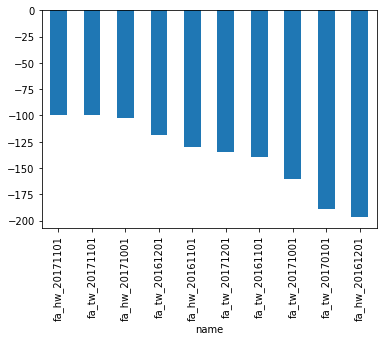

In [42]:
df = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_restart.1.est+fosm.rei")).loc[pst.nnz_obs_names,:]
df.sort_values(by="modelled",ascending=False).modelled.iloc[:10].plot(kind="bar")

Again we see that historic tail water flux is the binding constraint.  

## some reformulation of the opt problem. Can we open up decision variable (feasibility) space?

Lets reformulate the problem to be constrained by the total sw-gw flux across all reaches instead of splitting into headwaters and tailwaters.  Good thing we have added the list file budget components to the control file!

In [43]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_opt_restart.pst"))
obs = pst.observation_data
obs.loc[pst.nnz_obs_names,"obgnme"] = "sw-gw"  # hw and tw constraints from tagged "less_than"
obs.loc[pst.nnz_obs_names,"weight"] = 0.0

In [44]:
tot_swgw = obs.loc[obs.obsnme.str.startswith("flx_stream_"),"obsnme"]
tot_swgw

obsnme
flx_stream_leakage_20160101    flx_stream_leakage_20160101
flx_stream_leakage_20160201    flx_stream_leakage_20160201
flx_stream_leakage_20160301    flx_stream_leakage_20160301
flx_stream_leakage_20160401    flx_stream_leakage_20160401
flx_stream_leakage_20160501    flx_stream_leakage_20160501
flx_stream_leakage_20160601    flx_stream_leakage_20160601
flx_stream_leakage_20160701    flx_stream_leakage_20160701
flx_stream_leakage_20160801    flx_stream_leakage_20160801
flx_stream_leakage_20160901    flx_stream_leakage_20160901
flx_stream_leakage_20161001    flx_stream_leakage_20161001
flx_stream_leakage_20161101    flx_stream_leakage_20161101
flx_stream_leakage_20161201    flx_stream_leakage_20161201
flx_stream_leakage_20170101    flx_stream_leakage_20170101
flx_stream_leakage_20170201    flx_stream_leakage_20170201
flx_stream_leakage_20170301    flx_stream_leakage_20170301
flx_stream_leakage_20170401    flx_stream_leakage_20170401
flx_stream_leakage_20170501    flx_stream_leakage

In [45]:
obs.loc[tot_swgw,"obgnme"] = "less_than"
obs.loc[tot_swgw,"weight"] = 1.0
obs.loc[tot_swgw,"weight"] = obs_df.std().loc[pst.nnz_obs_names]
obs.loc[tot_swgw,"obsval"] = -200  # simple linear sum


Check your understanding:  we just reformulated the mgmt optimization problem to use the total sw-gw flux along all reaches instead of dividing the constraints into a headwater and tailwater reach grouping

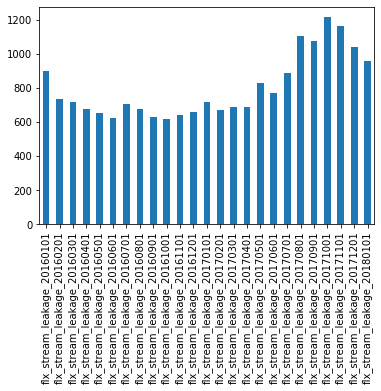

In [46]:
obs_df.std().loc[pst.nnz_obs_names].plot(kind="bar")

## risk sweeps

Since we really want to find the most risk averse stance that is still feasible we will run a sweep of risk values:

In [47]:
par_dfs = []
res_dfs = []
risk_vals = np.arange(0.05,1.0,0.05)
for risk in risk_vals:
    #try:
    #    os.remove(os.path.join(m_d,"freyberg_opt_restart.1.est+fosm.rei"))
    #except:
    #    pass
   
    pst.pestpp_options["opt_risk"] = risk
    pst.pestpp_options["opt_skip_final"] = True
    print("undertaking evaluation for risk value: {0:.2f}".format(risk))
    pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))
    pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)
    
    par_df = pyemu.pst_utils.read_parfile(os.path.join(m_d,"freyberg_opt_restart.1.par"))
    par_df = par_df.loc[dvg_pars,:]
    #when the solution is infeasible, pestpp-opt writes extreme negative values 
    # to the par file:
    if par_df.parval1.sum() < 6.0: 
        print("infeasible at risk {0:.2f}".format(risk))
        break
    
    res_df = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_restart.1.est+fosm.rei"))
    res_df = res_df.loc[pst.nnz_obs_names,:]
    res_dfs.append(res_df.modelled)
    par_dfs.append(par_df.parval1)

# process the dec var and constraint dataframes for plotting
risk_vals = risk_vals[:len(par_dfs)]
par_df = pd.concat(par_dfs,axis=1).T
par_df.index = risk_vals
par_df.index = par_df.index.map(lambda x: "{0:0.3f}".format(x))
res_df = pd.concat(res_dfs,axis=1).T
res_df.index = risk_vals
res_df.index = res_df.index.map(lambda x: "{0:0.3f}".format(x))

undertaking evaluation for risk value: 0.05
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.10
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.15
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.20
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.25
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.30
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.35
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.40
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.45
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.50
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.55
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.60
noptmax:1, npar_adj:46, nnz_obs:25
undertaking evaluation for risk value: 0.65
noptmax:

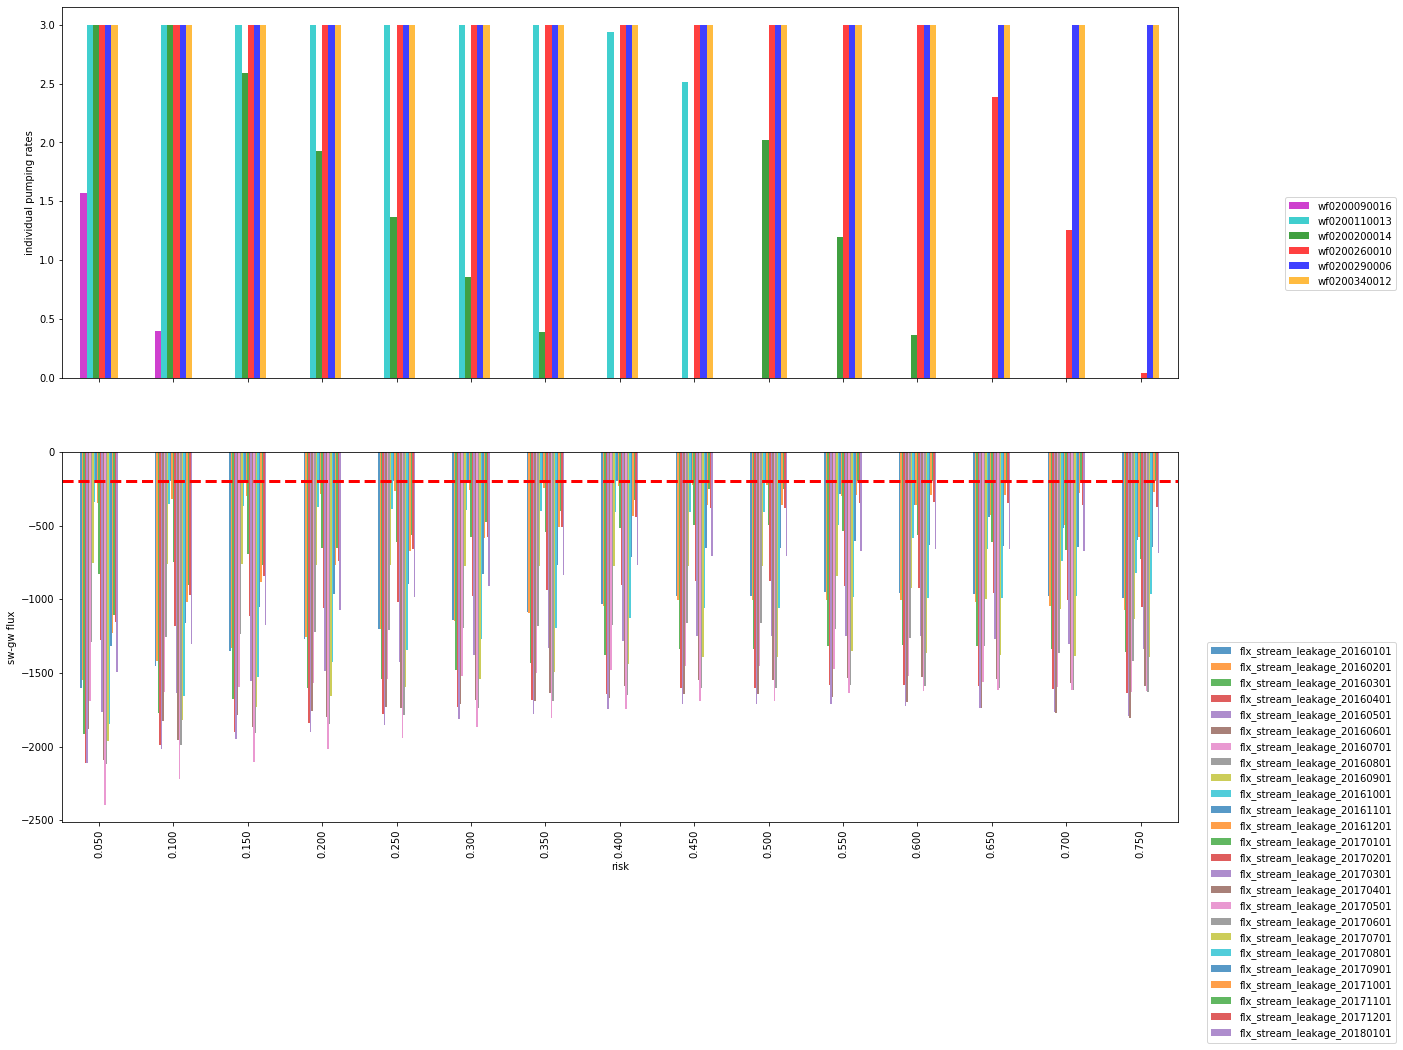

In [48]:
colors = ["m","c","g","r","b","orange"]
fig, axes = plt.subplots(2,1,figsize=(20,15))
par_df.plot(kind="bar",ax=axes[0],alpha=0.75,color=colors).legend(bbox_to_anchor=(1.2, 0.5))
axes[0].set_ylabel("individual pumping rates")
axes[0].set_xticklabels([])
res_df.plot(kind="bar",ax=axes[1],alpha=0.75,edgecolor="none").legend(bbox_to_anchor=(1.2, 0.5))
axes[1].plot(axes[1].get_xlim(),[-200,-200],"r--",lw=3)
axes[1].set_ylabel("sw-gw flux")
axes[1].set_xlabel("risk");

Now for some maps of pumping regimes

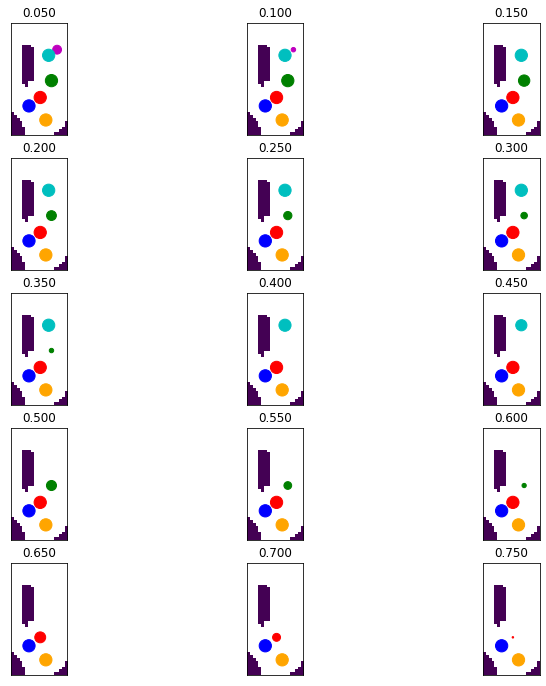

In [49]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d)

wf_par = pst.parameter_data.loc[dvg_pars,:].copy()
wf_par.loc[:,"k"] = wf_par.parnme.apply(lambda x: int(x[2:4]))
wf_par.loc[:,"i"] = wf_par.parnme.apply(lambda x: int(x[4:8]))
wf_par.loc[:,"j"] = wf_par.parnme.apply(lambda x: int(x[8:]))
wf_par.loc[:,"x"] = wf_par.apply(lambda x: m.sr.xcentergrid[x.i,x.j],axis=1)
wf_par.loc[:,"y"] = wf_par.apply(lambda x: m.sr.ycentergrid[x.i,x.j],axis=1)

ib = m.bas6.ibound[0].array
ib = np.ma.masked_where(ib!=0,ib)
fig,axes = plt.subplots(5,int(np.ceil(par_df.shape[0]/5)),figsize=(12,12))
axes = axes.flatten()
for risk,ax in zip(par_df.index,axes):
    ax.set_aspect("equal")
    #ax = plt.subplot(111,aspect="equal") 
    ax.imshow(ib,extent=m.sr.get_extent())
    ax.scatter(wf_par.x,wf_par.y,s=par_df.loc[risk,wf_par.parnme].values*50,c=colors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(risk)
    
for i in range(par_df.shape[0],axes.shape[0]):
    ax = axes[i]
    ax.axis("off")
    

How slick was that!  no more model runs needed and yet we transformed the OUU problem (by swapping constraints) and solved for a much more risk averse stance!  Just to make sure, lets run the model with the most risk-averse decision variables:

noptmax:1, npar_adj:46, nnz_obs:25


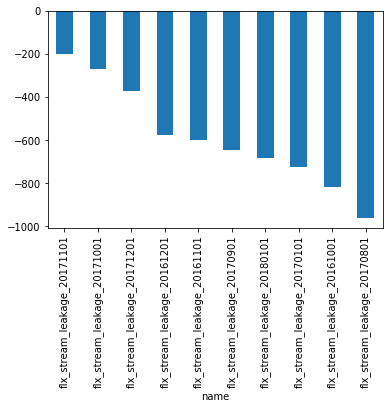

In [50]:
pst.pestpp_options["opt_risk"] = risk_vals[-1]
pst.pestpp_options["opt_skip_final"] = False
pst.write(os.path.join(m_d,"freyberg_opt_restart.pst"))
pyemu.os_utils.run("pestpp-opt freyberg_opt_restart.pst",cwd=m_d)
# load the simulated outputs plus the FOSM chance constraint offsets:
res_df = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_restart.1.sim+fosm.rei"))
res_df = res_df.loc[pst.nnz_obs_names,:]
res_df.sort_values(by="modelled",ascending=False).modelled.iloc[:10].plot(kind="bar")

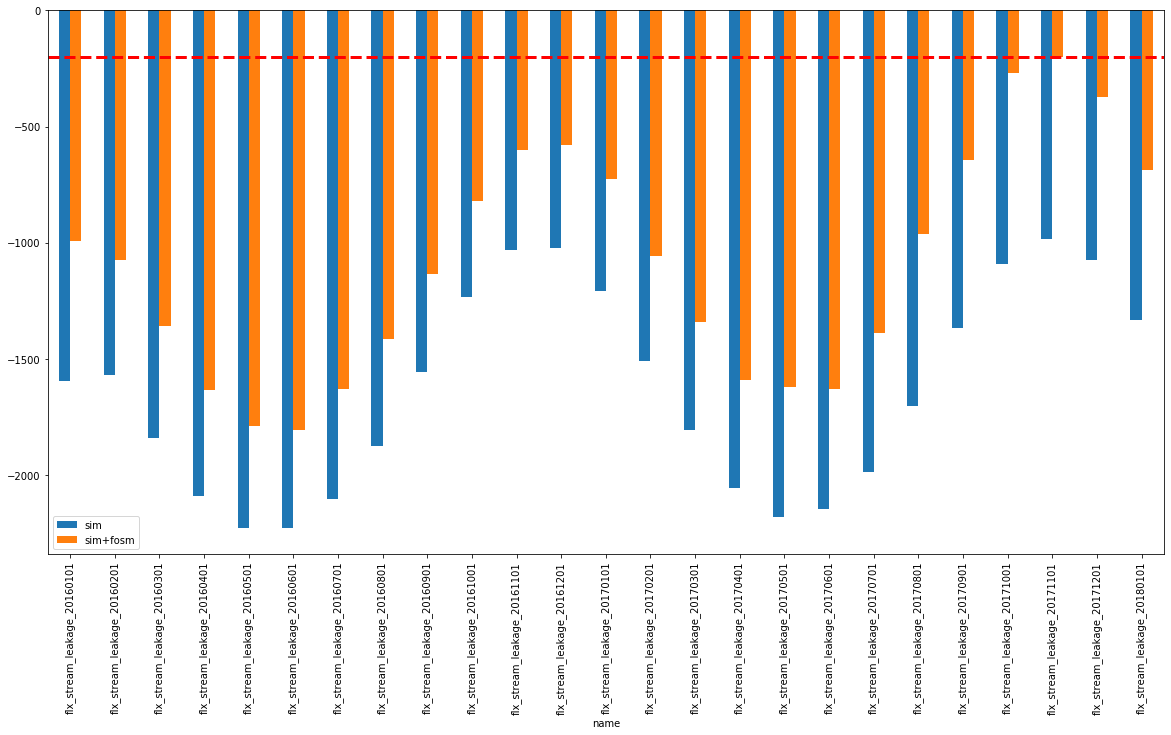

In [51]:
# load the actual model simulated outputs
res_df_sim = pyemu.pst_utils.read_resfile(os.path.join(m_d,"freyberg_opt_restart.1.sim.rei"))
res_df_sim = res_df_sim.loc[pst.nnz_obs_names,:]
ax = pd.DataFrame({"sim":res_df_sim.modelled,"sim+fosm":res_df.modelled}).plot(kind="bar",figsize=(20,10))
ax.plot(ax.get_xlim(),[-200,-200],"r--",lw=3)

Here we can see the cost of uncertainty - we have to simulate a greater flux from gw to sw to make sure (e.g. be risk averse) that the flux from  gw to sw is actually at least 200 m3/day


# FINALLY!!!

We now see the reason for high-dimensional uncertainty quantification and history matching: to define and then reduce (through data assimilation) the uncertainty in the model-based constraints (e.g. sw-gw forecasts) so that we can find a more risk-averse management solution - we can use a model to identify an optimal pumping scheme to provide the volume of water needed for water supply, agriculture, etc. but also provide assurances (at the given confidence) that ecological flows will be maintained under both current conditions and in the event of an extreme 1-year drought.  BOOM!